# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import gzip
import json
import torch

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import GPT2Tokenizer, GPT2LMHeadModel
sns.set_style('darkgrid')

/home/edilson07/.pyenv/versions/3.10.11/envs/sentiment_analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1.Load Data

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path, max_rows=100000):
  i = 0
  df = {}
  for d in parse(path):
    if i >= max_rows:
        break
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_raw = getDF('/home/edilson07/projects/sentiment_analysis/Electronics_5.json.gz')

In [3]:
df_raw.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,NaN
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,NaN
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,NaN
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,NaN
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,NaN


In [4]:
# Tranin Test Split
df_raw, X_test = train_test_split(df_raw, test_size=0.2, random_state=42, stratify=df_raw['overall'])

## 0.2 Drop Unecessary Columns

In [5]:
cols_to_select = ['overall','reviewText']

In [6]:
df_raw = df_raw[cols_to_select]

In [7]:
df_raw.head()

,overall,reviewText
82935,5.0,Does what it is supposed to do....the screen r...
54402,1.0,Defective out of the box. As with other custom...
80729,5.0,Great little radio. Well made and works well.
1797,4.0,The description of the book is right-on and th...
95092,5.0,Works good!


# 1.0 Transform Data

In [8]:
df = df_raw.copy()

/home/edilson07/.pyenv/versions/3.10.11/envs/sentiment_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/edilson07/.pyenv/versions/3.10.11/envs/sentiment_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/edilson07/.pyenv/versions/3.10.11/envs/sentiment_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='overall', ylabel='count'>

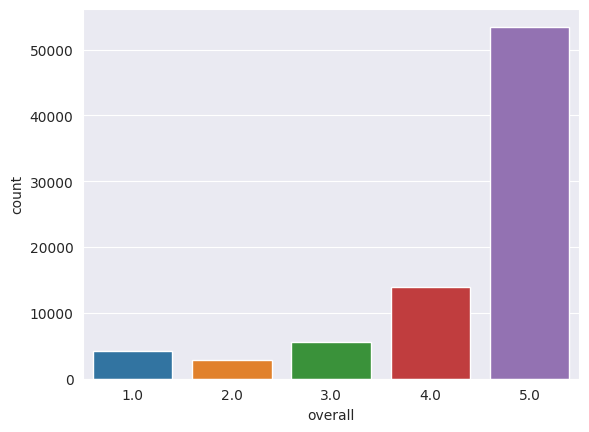

In [9]:
sns.countplot(df, x='overall')

In [10]:
sentiment_dict = {
    5.0 : 'Very Positive',
    4.0 : 'Positive',
    3.0 : 'Neutral',
    2.0 : 'Negative',
    1.0 : 'Negative'
}

In [11]:
df['overall'] = df['overall'].map(sentiment_dict)

In [12]:
df.head()

,overall,reviewText
82935,Very Positive,Does what it is supposed to do....the screen r...
54402,Negative,Defective out of the box. As with other custom...
80729,Very Positive,Great little radio. Well made and works well.
1797,Positive,The description of the book is right-on and th...
95092,Very Positive,Works good!


## 1.2 NaNs

In [13]:
df.isna().sum()
df = df.dropna()

# 2.0 Train-val split

In [14]:
train, validation = train_test_split(df, test_size=0.2, random_state=42, stratify=df['overall'])

# 3.0 Load Model

In [15]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

In [16]:
# def print_number_of_trainable_model_parameters(model):
#     trainable_model_params = 0
#     all_model_params = 0
#     for _, param in model.named_parameters():
#         all_model_params += param.numel()
#         if param.requires_grad:
#             trainable_model_params += param.numel()
#     return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

# print(print_number_of_trainable_model_parameters(model))

NameError: name 'model' is not defined

# Test model with One-Shot(GPT2)

In [17]:
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
# model = GPT2LMHeadModel.from_pretrained('gpt2-medium')

In [18]:
# index = 500
# index_example = 400

# review = train['reviewText'][index]
# sentiment = train['overall'][index]

# review_example = train['reviewText'][index_example]
# sentiment_example = train['overall'][index_example]

# prompt = f"""
# Analyze the sentiment of the following review.

# {review_example}

# Sentiment:

# {sentiment_example}


# Analyse the sentiment of the following review.

# {review}

# Sentiment:


# """



# inputs = tokenizer(prompt, return_tensors='pt', truncation=True, max_length=512)
# output = tokenizer.decode(
#     model.generate(
#         inputs['input_ids'],
#         max_length=512,
#         num_return_sequences=1,
#         no_repeat_ngram_size=2,
#         top_k=50,
#         top_p=0.95,
#         temperature=0.7
#     )[0],
#     skip_special_tokens=True
# )

# dash_line = '-'.join('' for x in range(100))
# print(dash_line)

# print(f'INPUT PROMPT:\n{prompt}')
# print(dash_line)
# print(f'BASELINE HUMAN SENTIMENT:\n{sentiment}\n')
# print(dash_line)
# print(f'MODEL GENERATION - One SHOT:\n{output}')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Analyze the sentiment of the following review.

I'm not sure how I did it, but miraculously I was able to attach this assembly to the back of my 55" LG.  Fortunately, this thing was meant to adapt to nearly unlimited orientations and configurations, so after a lot of finagling, I was able to position the arms so that they did not interfere with my power plugs or HDMI cable.

I'm hedging my rating since the product's directions did not mention that it would not work with my TV, and due to the effort required to get it to do so.

Sentiment:

Positive


Analyse the sentiment of the following review.

Bought it to hang my 43" Samsung Plasma. I really like the 24" reach. Lots of flexibility. very strong. Been using it for over half the year and hasn't shown signs of sag.

Only problem I have was that the mounting plate blocked the power cord from the TV! Therefore I had to plug

# Zero Shot with DistilBert

In [75]:
index = 500

review = train['reviewText'][index]
sentiment = train['overall'][index]

inputs = tokenizer(review, return_tensors='pt', truncation=True, max_length=512, padding='max_length')

# Obter a previsão
with torch.no_grad():
    logits = model(**inputs).logits
    predicted_label = torch.argmax(logits, dim=1).item()

print(predicted_label)

sentiment_map = {0: "Negative", 1: "Positive"}
predicted_sentiment = sentiment_map[predicted_label]

print(f"Predicted Sentiment: {predicted_sentiment}")

print(f'INPUT PROMPT:\n{review}')
print(dash_line)
print(f'BASELINE HUMAN SENTIMENT:\n{sentiment}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{predicted_sentiment}')

1
Predicted Sentiment: Positive
INPUT PROMPT:
Bought it to hang my 43" Samsung Plasma. I really like the 24" reach. Lots of flexibility. very strong. Been using it for over half the year and hasn't shown signs of sag.

Only problem I have was that the mounting plate blocked the power cord from the TV! Therefore I had to plug the cord (with some jigging around and loosening of screws) in first before mounting. One star off for this oddity. Or maybe it's a Samsung thing?
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SENTIMENT:
Positive

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
Positive


In [78]:
from transformers import AdamW, Trainer, TrainingArguments

# 1. Mapear sentimentos para IDs numéricos
sentiment_id_map = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2,
    'Very Positive': 3
}

train['sentiment_id'] = train['overall'].map(sentiment_id_map)
validation['sentiment_id'] = validation['overall'].map(sentiment_id_map)

# 2. Tokenizar os dados
train_encodings = tokenizer(list(train['reviewText']), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(validation['reviewText']), truncation=True, padding=True, max_length=512)

# Preparar os datasets no formato do Hugging Face
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, list(train['sentiment_id']))
val_dataset = SentimentDataset(val_encodings, list(validation['sentiment_id']))

# 3. Treinar o modelo
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=500,
    do_train=True,
    do_eval=True,
    output_dir='./results',
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

# 4. Validação
results = trainer.evaluate()

print(results)

/home/edilson07/.pyenv/versions/3.10.11/envs/sentiment_analysis/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


IndexError: Target 3 is out of bounds.